In [75]:
from queue import Queue
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array, dstack
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, LayerNormalization, Dense, Attention, MultiHeadAttention, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import pandas as pd
# import pygame
import sys
import os
#pygame.init()
# engine = pyttsx3.init() # object creation
SERIAL_PORT = '/dev/cu.DATN'
# be sure to set this to the same rate used on the Arduino
SERIAL_RATE = 38400
test_counter = 240
queue_size = 240
verbose, epochs, batch_size = 1, 1, 300
dataset_path = "./datatrain_40/total/"
trainx_file = "./datatrain_40/total/trainx.txt"
trainy_file = "./datatrain_40/total/trainy.txt"
testx_file = "./datatrain_40/total/testx.txt"
testy_file = "./datatrain_40/total/testy.txt"
config_file = "./datatrain_40/total/config.txt"
enlarged_dataset_path = "./datatrain_40/total/augmentation/"


# screen_width = 800
# screen_height = 600
# screen = pygame.display.set_mode((screen_width, screen_height))
# pygame.display.set_caption("Real-time Display")

# Set up fonts
#font = pygame.font.Font(None, 36)
#WHITE = (255, 255, 255)
""" RATE"""
#rate = engine.getProperty('rate')   # getting details of current speaking rate
# engine.setProperty('rate', 125)     # setting up new voice rate
"""VOLUME"""
#volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
#print (volume)                          #printing current volume level
# engine.setProperty('volume',1.0)    # setting up volume level  between 0 and 1

"""VOICE"""
#voices = engine.getProperty('voices')       #getting details of current voice
#engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
# engine.setProperty('voice', engine.getProperty('voices')[1].id)   #changing index, changes voices. 1 for female

# def textToSpeech(text):
#     engine.say(text)
#     engine.runAndWait()
#     engine.stop()
    

def readConfig():
    with open('./datatrain_40/total/config.txt', 'r',encoding='utf-8') as file:
        # Initialize an empty 2D array
        config = []

        # Iterate over each line in the file
        for line in file:
            # Split the line into individual words
            words = line.strip()

            # Append the words to the 2D array
            config.append(words)
        return config

def readdata(trainx_file, trainy_file, testx_file, testy_file):
    trainx_data =[]
    trainy_data =[]
    testx_data =[]
    testy_data =[]
    with open(trainx_file, 'r') as trainx, open(trainy_file, 'r') as trainy, open(testx_file, 'r') as testx, open(testy_file, 'r') as testy  :
        trainy_data = extract_y(trainy)
        testy_data = extract_y(testy)
        
        trainx_data = extract_data(trainx)
        testx_data = extract_data(testx)

    trainx_data = np.vstack(trainx_data)
    testx_data = np.vstack(testx_data)
    trainy_data = to_categorical(trainy_data)
    testy_data = to_categorical(testy_data)
    return trainx_data, trainy_data, testx_data, testy_data

def extract_data(file):
    data = []
    while True:
            try:
                x1 = []
                x2 = []
                x3 = []
                x4 = []
                x5 = []
                x6 = []
                x7 = []
                line = next(file).strip().split()
                if len(line) >= 1680:
                    for i in range(240):
                        x1.append(float(line[i]))
                        x2.append(float(line[i + 240]))
                        x3.append(float(line[i + 480]))
                        x4.append(float(line[i + 720]))
                        x5.append(float(line[i + 960]))
                        x6.append(float(line[i + 1200]))
                        x7.append(float(line[i + 1440]))
                else:
                    print("Error train data.")
                x1 = array(x1)
                x2 = array(x2)
                x3 = array(x3)
                x4 = array(x4)
                x5 = array(x5)
                x6 = array(x6)
                x7 = array(x7)
                line_dataset = dstack([x1, x2, x3, x4, x5, x6, x7]) 
                line_dataset = line_dataset.reshape(1,240,7)
                data.append(line_dataset)
            except StopIteration:
                break
    return data

def extract_y(file):
    y = []
    for line in file:
        y.append(line)
    y = array(y)
    data = np.vstack(y)
    data.reshape(1,len(y))
    return data


In [76]:
def positional_encoding(length, depth):
    depth = int(depth)
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)                # (1, depth)
    angle_rads = positions * angle_rates             # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class AddPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        _, seq_len, d_model = input_shape
        self.pos_encoding = positional_encoding(seq_len, d_model)

    def call(self, inputs):
        # Ensure positional encoding has the same shape as the input
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :tf.shape(inputs)[2]]

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config

In [77]:
def read_enlarged_data():
    data = []
    filenames = []
    for filename in os.listdir(enlarged_dataset_path):
        filenames.append(filename.split('.')[0])
        filepath = os.path.join(enlarged_dataset_path, filename)
        if os.path.isfile(filepath):
            with open(filepath, 'r') as file:
                train_data = np.vstack(extract_data(file))
                data.append(train_data)
    return data, filenames

def create_model(timesteps, features, num_classes, name = "original_model"):
    # define model
    model = Sequential(name=name)
    model.add(LSTM(units = 128, input_shape = (timesteps, features)))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(Dense(units = 64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model


def create_base_model(timesteps, n_features):
    inputs = Input(shape=(timesteps, n_features))

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = LSTM(units=128, return_sequences=True)(x)
    x = LSTM(units=128, return_sequences=True)(x)

    x = AddPositionalEncoding()(x)

    # MultiHeadAttention layer
    attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
    x = LayerNormalization()(attn_output + x)

    x = Dense(units=128, activation='relu')(x)

    # Global Attention layer
    attn = Attention()([x, x])
    x = LayerNormalization()(attn + x)

    # Global average pooling to reduce sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)


    model = Model(inputs=inputs, outputs= x)
    return model

def add_activation_layer(model, num_classes, name):
    x = Dense(units=num_classes, activation='softmax')(model.output)
    model = Model(inputs=model.input, outputs=x, name=name)
    return model

def evaluate_model(model, testX, testy,  class_names):
    print(f"Evaluate model {model.name}")

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(testy, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(xticks_rotation=60, ax=ax)
    plt.show()

    # return accuracy of the model
    return {'model_name': model.name, 'accuracy': np.mean(y_pred == y_true)}
    
def plot_val_loss(models, history):
    for model, h in zip(models, history):
        plt.plot(h.history['val_loss'], label=model.name)
    plt.title('model validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [78]:
def sequence_shuffle_pairs(X, y, seq_length):
    """
    Shuffle time series data and labels together in sequence chunks
    
    Args:
        X: features array of shape (n_samples, n_features)
        y: labels array of shape (n_samples,) or (n_samples, n_classes)
        seq_length: number of timesteps per sequence
    
    Returns:
        Tuple of (shuffled_X, shuffled_y)
    """
    # Verify input shapes match
    assert len(X) == len(y), "X and y must have same number of samples"
    
    # Calculate complete sequences
    n_samples = len(X)
    n_sequences = n_samples // seq_length
    
    # Trim to complete sequences
    X = X[:n_sequences * seq_length]
    y = y[:n_sequences * seq_length]
    
    # Reshape both into sequences
    X_sequences = X.reshape((n_sequences, seq_length, -1))
    y_sequences = y.reshape((n_sequences, seq_length, -1) if y.ndim > 1 else (n_sequences, seq_length))
    
    # Generate shuffle indices
    indices = np.random.permutation(n_sequences)
    
    # Apply same shuffling to both
    X_shuffled = X_sequences[indices].reshape((-1, X.shape[-1]))
    y_shuffled = y_sequences[indices].reshape((-1, y.shape[-1]) if y.ndim > 1 else (-1,))
    
    return X_shuffled, y_shuffled

# Example usage:
# X = np.array([[1,2], [3,4], [5,6], [7,8]])
# y = np.array([0, 0, 1, 1])
# X_shuffled, y_shuffled = sequence_shuffle_pairs(X, y, seq_length=2)

In [79]:
trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
class_names = readConfig()
timesteps, n_features, num_classes = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(4500, 240, 7) (4500, 5) (1500, 240, 7) (1500, 5)


In [80]:
trainX, trainy = sequence_shuffle_pairs(trainX, trainy, timesteps)
trainX = trainX.reshape(-1, timesteps, n_features)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(4320, 240, 7) (4320, 5) (1500, 240, 7) (1500, 5)


In [81]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

data_augmentation, techniques = read_enlarged_data()
models = []
history = []

scaler = MinMaxScaler()

#original model

original_model = create_base_model(timesteps, n_features)
original_model = add_activation_layer(original_model, num_classes, "original_model")
original_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history.append(original_model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
models.append(original_model)

old_model = create_model(timesteps, n_features, num_classes, "old_model")
old_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history.append(old_model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
models.append(old_model)


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.4109 - loss: 1.5532 - val_accuracy: 0.8530 - val_loss: 0.6316


c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 734ms/step - accuracy: 0.2588 - loss: 1.7394 - val_accuracy: 0.5162 - val_loss: 1.1608


In [82]:
trainX, trainy = sequence_shuffle_pairs(trainX, trainy, timesteps)
trainX = trainX.reshape(-1, timesteps, n_features)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

#original model with transfer learning
base_model = create_base_model(timesteps, n_features)
base_model.load_weights(f"./model/SADeepConvLSTM_TransferLearning_new.h5", by_name=True, skip_mismatch=True)
transfer_learning_model = add_activation_layer(base_model, num_classes, "transfer_learning_model")
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history.append(transfer_learning_model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
models.append(transfer_learning_model)

(4320, 240, 7) (4320, 5) (1500, 240, 7) (1500, 5)


c:\Python311\Lib\site-packages\keras\src\saving\saving_api.py:269: UserWarning: Skipping loading top-level weights for model due to mismatch in number of weights. Model expects 28 top-level weight(s). Received 0 saved top-level weight(s)
  legacy_h5_format.load_weights_from_hdf5_group_by_name(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step - accuracy: 0.3909 - loss: 1.9448 - val_accuracy: 0.5926 - val_loss: 0.7812


In [83]:
#original model with data augmentation
trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
augmented_data = np.vstack(data_augmentation)
augmented_data = np.vstack([trainX, augmented_data])
augmented_data_y = np.concatenate([trainy] * (len(data_augmentation) + 1), axis=0)
augmented_data, augmented_data_y = sequence_shuffle_pairs(augmented_data, augmented_data_y, timesteps)
augmented_data = augmented_data.reshape(-1, timesteps, n_features)
augmented_data_model = create_base_model(timesteps, n_features)
augmented_data_model = add_activation_layer(augmented_data_model, num_classes, "data_augmentation")
augmented_data_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history.append(augmented_data_model.fit(augmented_data, augmented_data_y, epochs=5, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
models.append(augmented_data_model)

Epoch 1/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8702 - loss: 0.3969WARNING:tensorflow:5 out of the last 22 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x000001E6E40AB2E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.8709 - loss: 0.3948 - val_accuracy: 0.9994 - val_loss: 0.0032
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 37s 277ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 2.9322e-04
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.9998 - loss: 8.3711e-04 - val_accuracy: 0.9939 - val_loss: 0.0220
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 37s 277ms/step - accuracy: 0.9993 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 2.6220e-04
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9997 - val_loss: 0.0011


In [84]:
#original model with synthetic data from timegan
trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
synthetic_path = "synthetic_data"
trainy_synthetic = np.argmax(trainy, axis=1)
class_labels_synthetic = np.unique(trainy_synthetic)
synthetic_data = []
synthetic_data_y = []
for i in range(len(class_labels_synthetic)):
    temp = pd.read_csv(f"{synthetic_path}/{i}.csv")
    synthetic_data.append(temp)

synthetic_data = np.vstack(synthetic_data)
synthetic_data = synthetic_data.reshape(-1, timesteps, n_features)
synthetic_data = np.vstack([trainX, synthetic_data])
synthetic_model = create_base_model(timesteps, n_features)
synthetic_data_y = np.vstack([trainy, trainy])
synthetic_data, synthetic_data_y = sequence_shuffle_pairs(synthetic_data, synthetic_data_y, timesteps)
synthetic_data = synthetic_data.reshape(-1, timesteps, n_features)
synthetic_model = add_activation_layer(synthetic_model, num_classes, "synthetic_model")
synthetic_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history.append(synthetic_model.fit(synthetic_data, synthetic_data_y, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
models.append(synthetic_model)

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - accuracy: 0.4651 - loss: 1.5030 - val_accuracy: 0.9628 - val_loss: 0.1350


In [85]:
models_accuracy = []

In [86]:
def plot_confidence(X, y, models):
    confidences = []
    for model in models:
        temp = model.predict(X)
        #filter out the correct guess only
        y_pred = np.argmax(temp, axis=1)
        y_true = np.argmax(y, axis=1)
        correct_indices = np.where(y_pred == y_true)[0]
        correct_predictions = temp[correct_indices]
        correct_predictions = np.max(correct_predictions, axis=1)
        average_confidence = np.mean(correct_predictions)
        confidences.append(average_confidence)
    # confidences.append(0.91)
    bars = plt.bar([model.name for model in models], confidences)
    for bar, confidence in zip(bars, confidences):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f"{confidence:.2f}", ha='center', va='bottom')

    plt.ylabel('Average confidence')
    plt.show()
        
        
# plot_confidence(testX, testy, models)

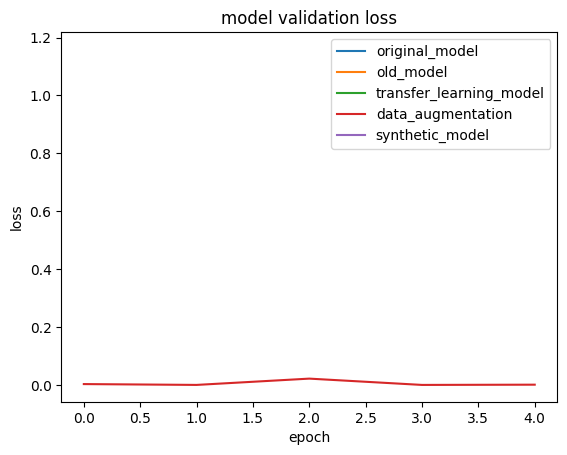

Evaluate model original_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
              precision    recall  f1-score   support

    Xin chào       0.84      0.98      0.91       299
         Tôi       0.73      1.00      0.84       300
         Tên       0.96      1.00      0.98       300
        Tiến       1.00      1.00      1.00       300
    Tạm biệt       1.00      0.44      0.61       301

    accuracy                           0.88      1500
   macro avg       0.91      0.88      0.87      1500
weighted avg       0.91      0.88      0.87      1500



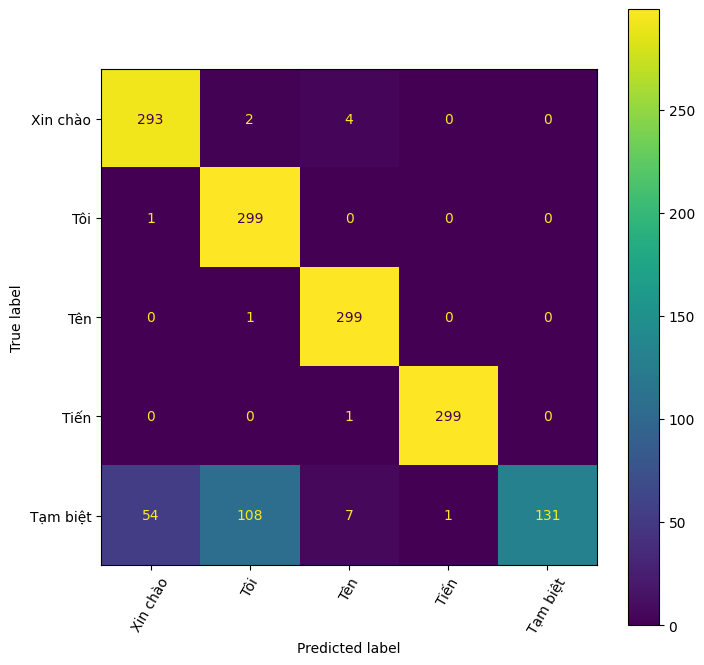

Evaluate model old_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
              precision    recall  f1-score   support

    Xin chào       0.39      0.82      0.53       299
         Tôi       0.90      0.92      0.91       300
         Tên       0.86      0.39      0.54       300
        Tiến       0.85      1.00      0.92       300
    Tạm biệt       0.76      0.20      0.31       301

    accuracy                           0.66      1500
   macro avg       0.75      0.67      0.64      1500
weighted avg       0.75      0.66      0.64      1500



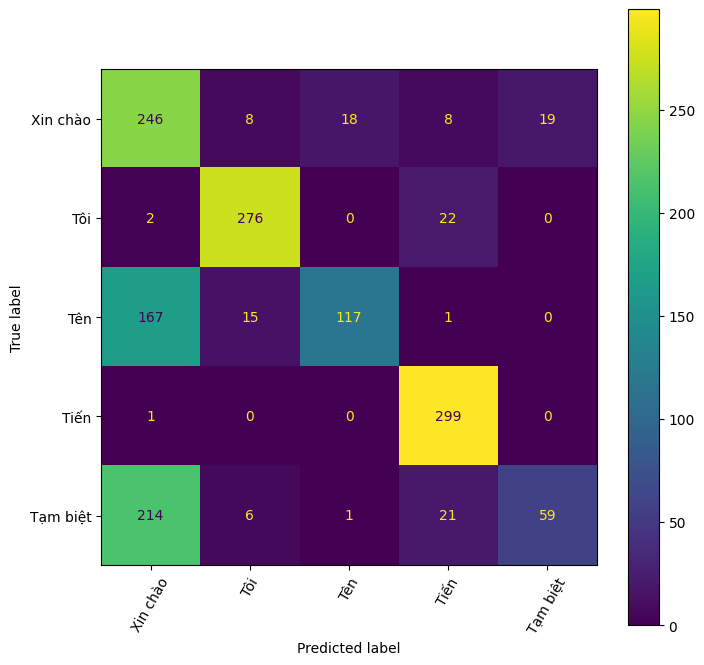

Evaluate model transfer_learning_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
              precision    recall  f1-score   support

    Xin chào       0.53      0.98      0.69       299
         Tôi       0.95      0.97      0.96       300
         Tên       0.97      0.99      0.98       300
        Tiến       0.97      1.00      0.98       300
    Tạm biệt       1.00      0.07      0.14       301

    accuracy                           0.80      1500
   macro avg       0.89      0.80      0.75      1500
weighted avg       0.89      0.80      0.75      1500



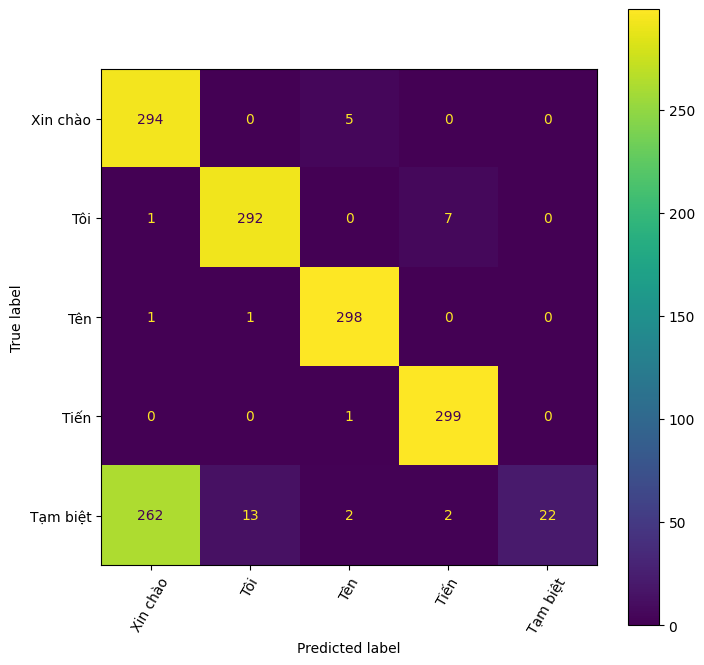

Evaluate model data_augmentation
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
              precision    recall  f1-score   support

    Xin chào       0.99      1.00      0.99       299
         Tôi       1.00      1.00      1.00       300
         Tên       1.00      1.00      1.00       300
        Tiến       1.00      1.00      1.00       300
    Tạm biệt       1.00      0.99      0.99       301

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



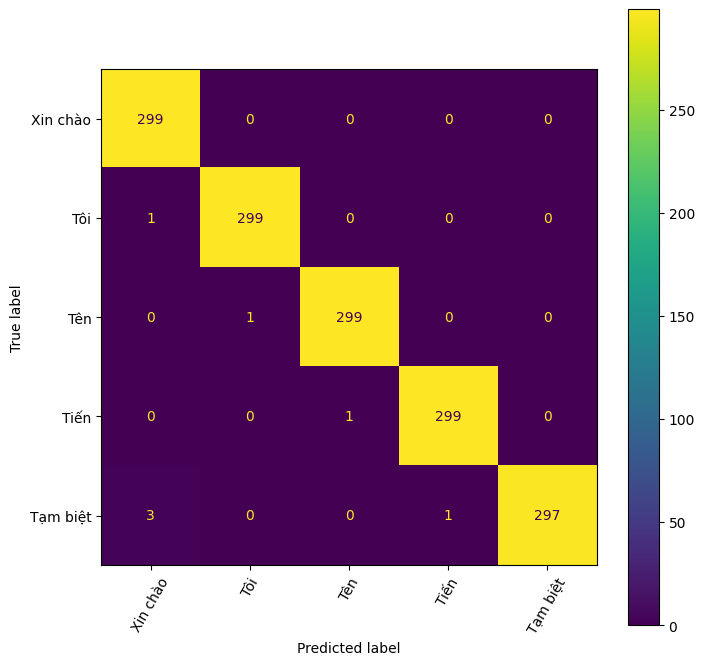

Evaluate model synthetic_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
              precision    recall  f1-score   support

    Xin chào       0.97      0.89      0.93       299
         Tôi       1.00      1.00      1.00       300
         Tên       0.90      1.00      0.95       300
        Tiến       1.00      1.00      1.00       300
    Tạm biệt       0.99      0.97      0.98       301

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



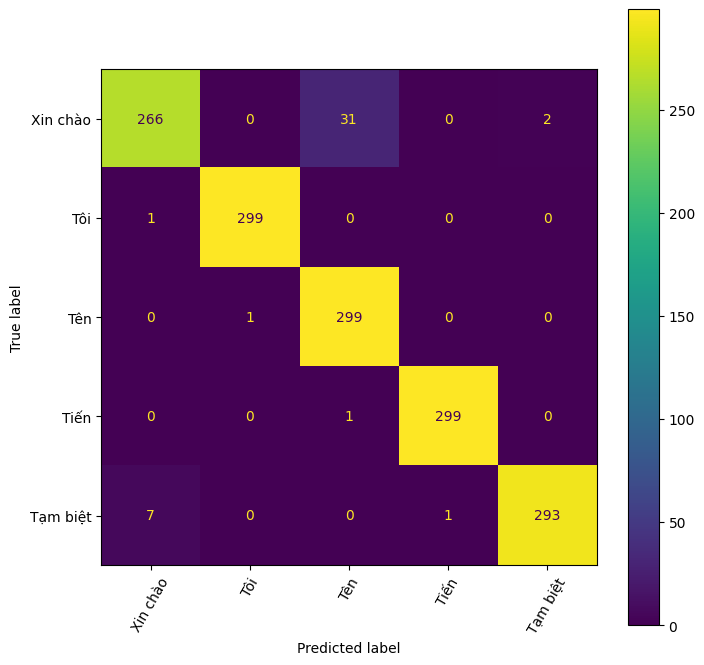

In [87]:
plot_val_loss(models, history)

for model in models:
    # testX = scaler.fit_transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    model.save(f"./evaluation_model/{model.name}.h5")
    models_accuracy.append(evaluate_model(model, testX, testy, class_names))


Text(0.5, 1.0, 'Model Accuracy')

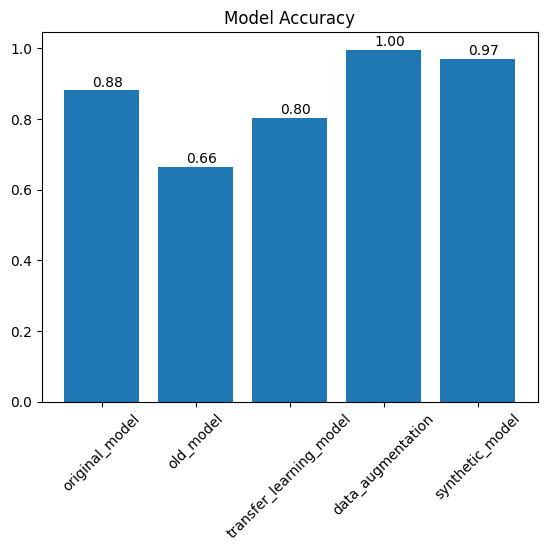

In [88]:
# plot bar chart of the accuracy of each model
accuracy = [model['accuracy'] for model in models_accuracy]
model_name = [model['model_name'] for model in models_accuracy]
plt.bar(model_name, accuracy)
for i, v in enumerate(accuracy):
    #round to 2 decimal places
    # plt.text(i - 0.1, v + 0.01, str(v))
    plt.text(i - 0.1, v + 0.01, f"{v:.2f}")
plt.xticks(rotation=45)
plt.title('Model Accuracy')